In [1]:
import scprep
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import graphtools as gt

#from gprofiler import GProfiler
import os
import tasklogger
import pickle
import re # regexp
import itertools

import sklearn.cluster
import magic
import phenograph
import louvain
import umap
import phate
from sklearn.manifold import TSNE

import gseapy

#import anndata, scanpy
#plt.rcParams['figure.figsize']=(6,6) #rescale figures
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def select_genes(data, genelist) : 

    collist = [];
    genesymbolslist = [];
    
    for g in genelist :
        sublist = [col for col in data.columns if re.match(g, col)]
        
        splitnames = [s.split(' ') for s in sublist]
        genesymbols = [g[0] for g in splitnames];
        
        genesymbolslist = genesymbolslist + genesymbols;
        collist = collist + sublist;

    [names, index] = np.unique(collist,return_index=True)
    collist = [collist[i] for i in index]
    genesymbolslist = [genesymbolslist[i] for i in index]

    return collist, genesymbolslist

def get_genes_expression(data, genelist) :
    
    collist, __ = select_genes(data, genelist)  
    expr = data[collist] 
    expr = np.sum(expr,axis=1) 
    return expr

def plot_genes(visualization, data, genelist) :

    collist, genelist = select_genes(data, genelist)
    
    nrows = int(np.ceil(len(collist)/5));
    if nrows > 1 :
        fig, axes = plt.subplots(nrows, 5, figsize=(20, nrows*4))
    else :
        fig, axes = plt.subplots(nrows, len(collist), figsize=(len(collist)*4, nrows*4))

    vis_pd = pd.DataFrame(visualization, index=data.index)
    
    for i in range(0,len(collist)) :
        rowi = int(np.floor(i/5))
        coli = i%5
        
        expression = scprep.select.select_cols(data, exact_word=genelist[i])
        sort_index = expression.sort_values().index
    
        figax = axes[rowi,coli] if nrows > 1 else axes[coli]
        scprep.plot.scatter2d(vis_pd.loc[sort_index], c=expression.loc[sort_index], title=genelist[i],
                      ticks=False, ax=figax, label_prefix='PHATE')
        
        plt.tight_layout()

In [4]:
# LIST OF INTERESTING GENES

coremarkers = ['^SOX2($| )','^TBXT($| )','^SOX17($| )','^ISL1($| )'] 

epiblast = ['^SOX2(($| )| )','^NANOG($| )','^POU5F1($| )','^KLF4($| )','^OTX2($| )','^ESRG($| )','^DPPA4($| )']
mesoderm = ['^GSC($| )','^TBXT($| )','^MIXL1($| )','^EOMES($| )','^TBX6($| )','^MESP1($| )','^GATA6($| )','^GATA4($| )','^MSGN1($| )','^PDGFRA($| )','^EPHA4($| )','^ZIC3($| )'] # ,'EPHA4','ZIC3' Zhou..Lanner..Chien embryonic mesoderm
exmeso = ['^PODXL($| )','^ETS1($| )'] #Zhou..Lanner...
endoderm = ['OTX2($| )','PRDM1($| )','SOX17($| )','FOXA2($| )','HHEX($| )','LHX1($| )','TTR($| )','GATA4($| )','KIT($| )','CXCR4($| )']
ectoderm = ['^SOX1($| )', '^SOX2($| )', '^SOX3($| )','NES']
TE = ['CGA($| )','XAGE3($| )','PGF($| )','WNT3A($| )']
amnion = ['ISL1($| )','BMP4($| )','GABRP($| )','HEY1($| )','LYPD1($| )','WNT6($| )']#,'WFDC2($| )','ANXA3($| )','CDO1($| )'] #Zhou..Lanner...
exMC = ['VIM($| )','COL3A1','HGF','COL6A2','HAND2($| )','COL1A1','POSTN']
extraembryonic = ['CDX2($| )', 'GATA2($| )','GATA3($| )','HAND1($| )','TBX3($| )','TFAP2A($| )','DLX5($| )','KRT18($| )','KRT7($| )','TP63($| )'] + TE + amnion + exmeso + exMC;

PGC = ['PRDM1($| )','SOX17($| )','TFAP2C($| )','NANOG($| )','ALPP($| )','DPPA4($| )','NANOS3($| )','LAMA4($| )','KLF4($| )','KIT($| )','CXCR4($| )','DDX4($| )','DAZL($| )','DPPA3($| )'] # DDX4=VASA, DPPA3=stella
endothelium = ['PECAM1($|c )', 'MEF2C($| )']
blood = ['RUNX1($| )','GATA1($| )','HBE1($| )']
heart = ['NKX2-5($| )','MESP1($| )','TBX1($| )','TBX5($| )','ISL1($| )','TNNT2($| )']
lung = ['NKX2-1($| )']
organs = endothelium + blood + heart + lung

HOX = ['HOX[ABCD][1-9]+($| )'];

germmarkers =  list(np.unique(epiblast + mesoderm + endoderm + ectoderm + extraembryonic + PGC))
allmarkers = list(np.unique(germmarkers + organs + HOX))

coreligands = ['DKK[1-9]($| )',"LEFTY[1-2]($| )","NODAL($| )","WNT3($| )","WNT3A($| )","WNT6($| )","WNT5A($| )","WNT5B($| )","BMP2($| )","BMP4($| )","BMP7($| )","^CER1($| )","NOG($| )",'FGF2($| )','FGF4($| )','FGF8($| )','FGF17($| )']
TGFbtransduction = ['SMAD[1-9]($| )','^ACVR[1-2][ABC]*($| )','BMPR[1-2][ABC]*($| )','TGFBR','TDGF1($| )']
wnt = ['WNT[1-9]+[AB]*($| )','RSPO[1-9]($| )','FZD[1-9]*($| )','^DVL']
othersignaling = ['^EGF($| )','^EGFR($| )']

FGFR = ['^FGFR[1-4]($| )']
extracell_FGFact = ['^KL($| )','^GLG1($| )','^FLRT($| )', '^KAL1($| )'] # klotho, cfr, flrt, anosmin-1
extracell_FGFinh = ['^FGFRL1','^IL17RD'] # FGFRL1, SEF
intracell_ERKinh = ['^SPRY[1-4]($| )','^DUSP[1-9]($| )','^DUSP10($| )','^DUSP14($| )','^DUSP26($| )','^PEBP1($| )']
intracell_ERKact = ['^MAP2K[1-2]($| )','^MAPK3($| )','^MAPK1($| )','^ARAF($| )','^BRAF($| )','^RAF1($| )'] #K3 = ERK1, #K1 = ERK2, MEK1/2 are phosporylated by RAS
HSPG_synthesis = ['^EXT1($| )','^EXT2($| )','^UGDH($| )'] # EXT catalyze HS side chain elongation, UGDH : Garcia-Garcia & Anderson, makes side chains
HSPG = ['^HSPG2($| )', '^AGRIN($| )', '^SDC[1-4]($| )', '^GPC[1-9]($| )'] # HSPG2: perlecan (secreted), agrin=secreted, syndecan=transmembrane, glypican (GPI-anchored)
HSPG_desulf = ['^SULF'] # 6-O sulfatases - inhibit FGF
HSPG_shedding = ['^HPSE($| )', '^HTRA1($| )'] # heparanase
HSPG_sulfotransferase = ['^HS6ST','^HS2ST', '^HS3ST', '^NDST'] 

FGF_inhibition = HSPG_desulf + extracell_FGFinh + intracell_ERKinh
FGF_activation = FGFR + extracell_FGFact + HSPG_synthesis + HSPG + HSPG_shedding + HSPG_sulfotransferase + intracell_ERKact

FGF_modulation = FGF_inhibition + FGF_activation

allsignaling = coreligands + TGFbtransduction + FGF_modulation + wnt + othersignaling;

EMT = ['^CDH[1-2]($| )','VIM($| )','EPCAM($| )','SNAI[1-2]($| )','^PAI[1-3]($| )']

allgenes = list(np.unique(allmarkers + allsignaling + EMT))

In [5]:
len(allgenes) # just the regexp list length, not number of genes

146

In [6]:
# read the data
dataDir = '/Users/idse/data_tmp/scRNAseq/human_gastrula/';
countMatrixFile = dataDir + 'human_gastrula_expression_values.csv';
annotationFile = dataDir + 'annot_umap.csv';
cc_genes_file = dataDir + 'Macosko_cell_cycle_genes.txt'

In [7]:
data = pd.read_csv(countMatrixFile,index_col='Unnamed: 0');
annotation = pd.read_csv(annotationFile,index_col='Unnamed: 0');

In [8]:
annotation

,X,X0,X1,cluster_id,sub_cluster,cell_name
1,0,12.213498,-0.550328,Hemogenic Endothelial Progenitors,Blood Progenitors,SS.sc7785290
2,1,2.404149,-7.389468,Endoderm,DE(P),SS.sc7786612
3,2,6.219126,-2.577739,Advanced Mesoderm,Advanced Mesoderm,SS.sc7786605
4,3,1.528913,0.412943,Primitive Streak,Primitive Streak,SS.sc7785737
5,4,9.373722,4.137366,ExE Mesoderm,YS Mesoderm,SS.sc7785398
...,...,...,...,...,...,...
1191,1190,0.538678,3.815438,Epiblast,Epiblast,SS.sc7785965
1192,1191,2.494623,1.739064,Primitive Streak,Primitive Streak,SS.sc7788259
1193,1192,0.190426,1.626420,Primitive Streak,Primitive Streak,SS.sc7786123
1194,1193,0.720511,3.806959,Epiblast,Epiblast,SS.sc7786212


In [9]:
data

,A1BG,A1BG.AS1,A1CF,A2M,A2M.AS1,A2ML1,A2ML1.AS1,A2ML1.AS2,A2MP1,A3GALT2,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZYXP1,ZZEF1,hsa.mir.1253
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,5.117682,0.0,0.0,0.0
2,1.392672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.508156,0.0,0.0,1.686027,0.000000,0.0,0.0,0.0
4,1.305855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,5.395007,0.000000,0.0,0.0,0.0
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,2.575553,0.0,0.0,0.0
1192,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1193,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1194,2.130417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,1.330224,0.000000,0.0,0.0,0.0


## Quality control and filtering

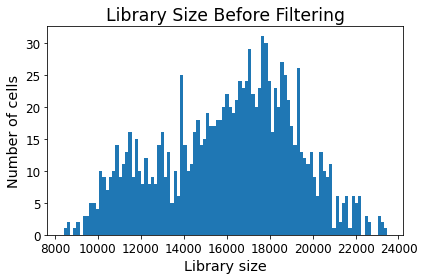

In [10]:
scprep.plot.plot_library_size(data, log=False, title='Library Size Before Filtering');

<AxesSubplot:xlabel='Gene expression', ylabel='Number of cells'>

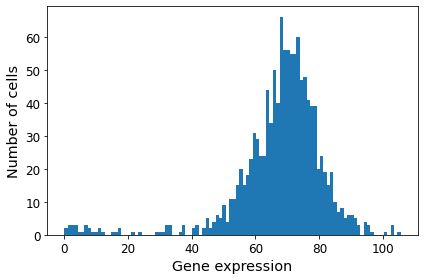

In [11]:
# Plot all mitochondrial genes. There are 14, FYI.
#mtgenes = scprep.select.get_gene_set(data, starts_with="MT-")
mtcutoff = [150,950];
scprep.plot.plot_gene_set_expression(data, starts_with="MT.")#,
                                     #library_size_normalize=True, cutoff=mtcutoff,
                                     #title="Mitochrondrial expression before filtering");

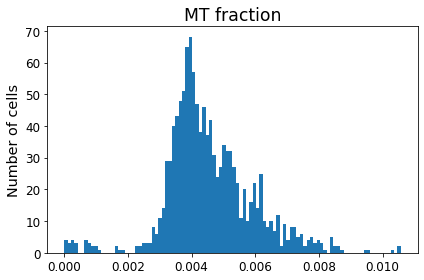

In [12]:
# check mitochondrial fraction 
MTgenes = [col for col in data.columns if re.match('MT\.', col)];
mt_expr = get_genes_expression(data, MTgenes)  
libsize = np.sum(data, axis=1)
mt_frac = mt_expr/libsize
scprep.plot.histogram(mt_frac, title='MT fraction');

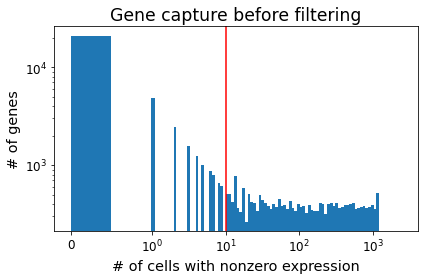

In [13]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data), log=True, cutoff=10,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes');

In [14]:
data_filt = scprep.filter.filter_rare_genes(data, min_cells=10)

In [15]:
print(data.shape)
print(data_filt.shape)

(1195, 57490)
(1195, 22413)


In [16]:
collist, symbolslist = select_genes(data, allgenes);
print(len(collist))
collist, symbolslist = select_genes(data_filt, allgenes);
print(len(collist))

266
220


## Normalization, transformation and denoising

In [17]:
data_norm, library_size = scprep.normalize.library_size_normalize(data_filt, return_library_size=True)
data_sqrt = scprep.transform.sqrt(data_norm)

In [18]:
data_sqrt_magic = magic.MAGIC().fit_transform(data_sqrt)

Calculating MAGIC...
  Running MAGIC on 1195 cells and 22413 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.19 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.14 seconds.
    Calculating affinities...
    Calculated affinities in 0.13 seconds.
  Calculated graph and diffusion operator in 1.57 seconds.
  Running MAGIC with `solver='exact'` on 22413-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.25 seconds.
Calculated MAGIC in 1.92 seconds.


## Plot UMAP and annotation

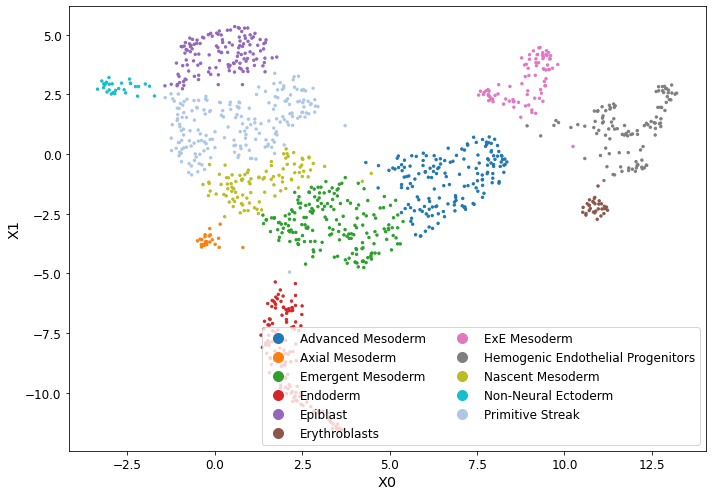

In [19]:
UMAP = annotation[['X0','X1']];
scprep.plot.scatter2d(UMAP,c=annotation['cluster_id'],figsize=(10,7),legend=True);

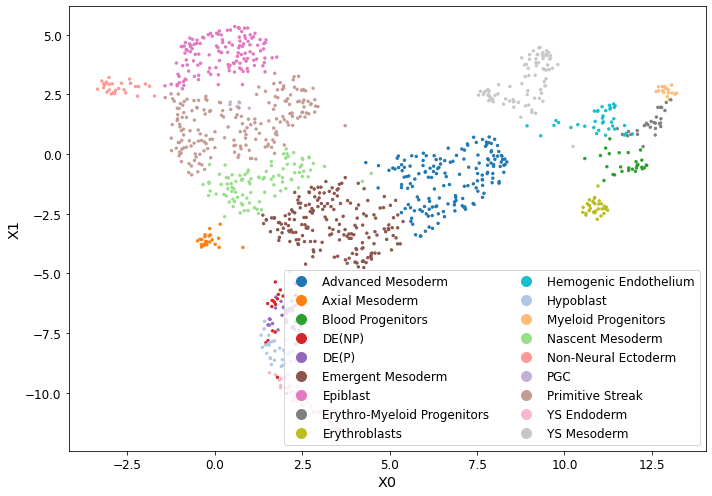

In [20]:
UMAP = annotation[['X0','X1']];
scprep.plot.scatter2d(UMAP,c=annotation['sub_cluster'],figsize=(10,7),legend=True);

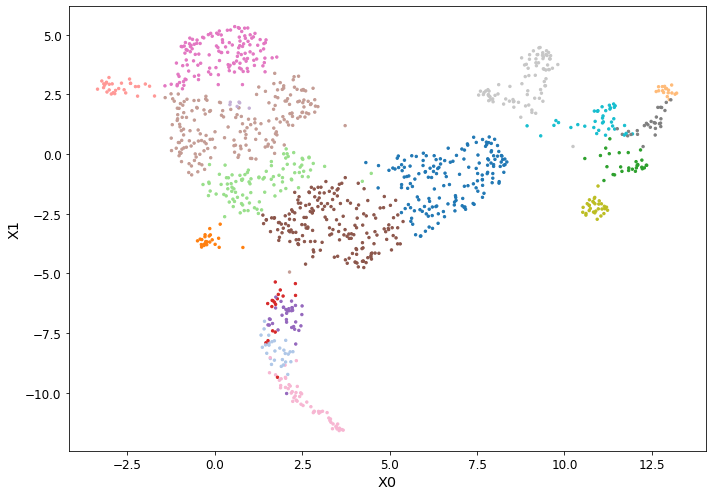

In [22]:
UMAP = annotation[['X0','X1']];
scprep.plot.scatter2d(UMAP,c=annotation['sub_cluster'],figsize=(10,7),legend=False);

In [23]:
clusternames = np.unique(annotation['cluster_id'])
print(clusternames)

['Advanced Mesoderm' 'Axial Mesoderm' 'Emergent Mesoderm' 'Endoderm'
 'Epiblast' 'Erythroblasts' 'ExE Mesoderm'
 'Hemogenic Endothelial Progenitors' 'Nascent Mesoderm'
 'Non-Neural Ectoderm' 'Primitive Streak']


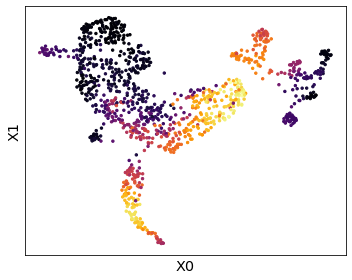

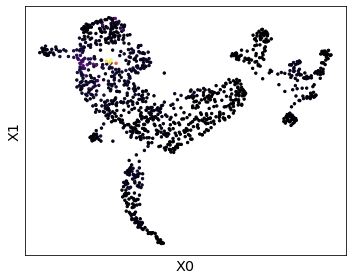

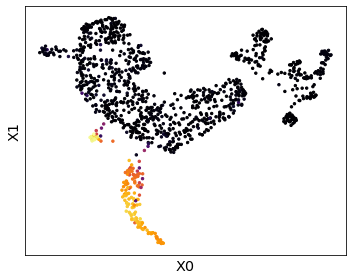

In [26]:
UMAP = annotation[['X0','X1']];
scprep.plot.scatter2d(UMAP,c=data_sqrt_magic['GATA6'],figsize=(5,4),legend=False,ticks=False);
scprep.plot.scatter2d(UMAP,c=data_sqrt_magic['NANOS3'],figsize=(5,4),legend=False,ticks=False);
scprep.plot.scatter2d(UMAP,c=data_sqrt_magic['FOXA2'],figsize=(5,4),legend=False,ticks=False);

In [27]:
# z-score all data
data_sqrt_zscore = sklearn.preprocessing.StandardScaler().fit_transform(data_sqrt.to_numpy())

In [28]:
clusters = annotation['cluster_id'];
Nclusters = len(clusternames)
Ngenes = data_filt.shape[1]
cluster_means = np.zeros((Nclusters, Ngenes))
cluster_means_zscore = np.zeros((Nclusters, Ngenes))
data_sqrt_np = data_sqrt.to_numpy()

for i in range(0, Nclusters) :
    cluster_means[i,:] = np.mean(data_sqrt_np[clusters==clusternames[i],:],axis=0)
    cluster_means_zscore[i,:] = np.mean(data_sqrt_zscore[clusters==clusternames[i],:],axis=0)
    
cluster_means = pd.DataFrame(cluster_means, columns=data_sqrt.columns, index=clusternames)
cluster_means_zscore = pd.DataFrame(cluster_means_zscore, columns=data_sqrt.columns, index=clusternames)

In [34]:
data_sqrt_np = data_sqrt.to_numpy()
data_sqrt_np[clusters==clusternames[1],:].shape

(23, 22413)

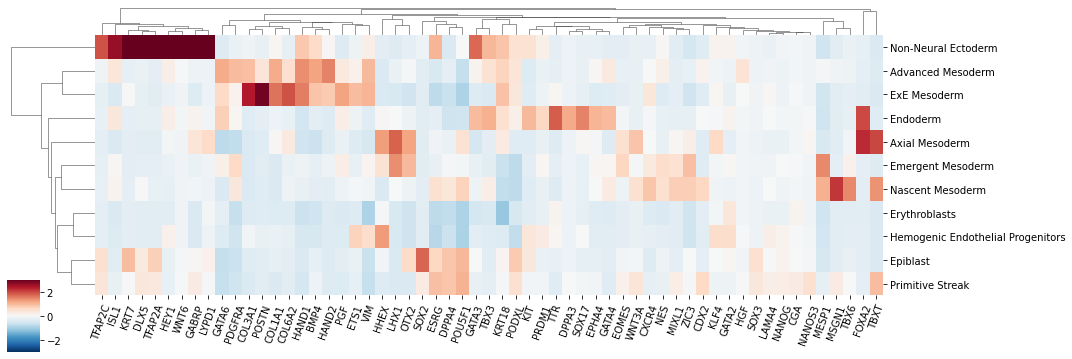

In [60]:
cols, symbols = select_genes(data_sqrt, germmarkers) # germmarkers
g = sb.clustermap(cluster_means_zscore[cols], xticklabels=symbols,vmax=3,vmin=-3,dendrogram_ratio=0.1,figsize=(15,5),cbar_pos=(0.01,0.01,0.03,0.2),cmap='RdBu_r');
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=70)
plt.savefig(dataDir+'clustermap_germmarkers_louvain.png', bbox_inches='tight');

In [58]:
sub_clusternames = np.unique(annotation['sub_cluster'])

In [59]:
sub_clusters = annotation['sub_cluster'];
Nclusters = len(sub_clusternames)
Ngenes = data_filt.shape[1]
sub_cluster_means = np.zeros((Nclusters, Ngenes))
sub_cluster_means_zscore = np.zeros((Nclusters, Ngenes))

for i in range(0, Nclusters) :
    sub_cluster_means[i,:] = np.mean(data_sqrt_np[sub_clusters==sub_clusternames[i],:],axis=0)
    sub_cluster_means_zscore[i,:] = np.mean(data_sqrt_zscore[sub_clusters==sub_clusternames[i],:],axis=0)
    
sub_cluster_means = pd.DataFrame(sub_cluster_means, columns=data_sqrt.columns, index=sub_clusternames)
sub_cluster_means_zscore = pd.DataFrame(sub_cluster_means_zscore, columns=data_sqrt.columns, index=sub_clusternames)

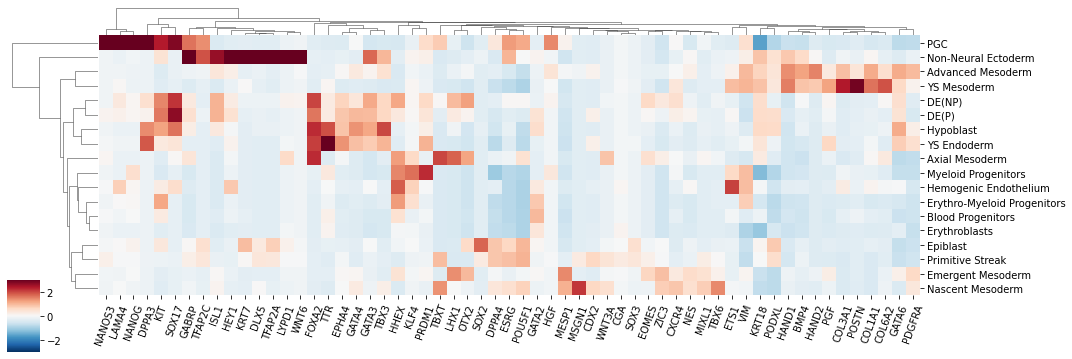

In [61]:
cols, symbols = select_genes(data_sqrt, germmarkers) # germmarkers
g = sb.clustermap(sub_cluster_means_zscore[cols], xticklabels=symbols,vmax=3,vmin=-3,dendrogram_ratio=0.1,figsize=(15,5),cbar_pos=(0.01,0.01,0.03,0.2),cmap='RdBu_r');
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=70)
plt.savefig(dataDir+'subclustermap_germmarkers_louvain.png', bbox_inches='tight');

In [25]:
cols, symbols = select_genes(data_sqrt, allgenes)
M = cluster_means_zscore[cols].T
clustercorr = scprep.stats.pairwise_correlation(M, M)
clustercorr_df = pd.DataFrame(clustercorr,columns=clusternames,index=clusternames)

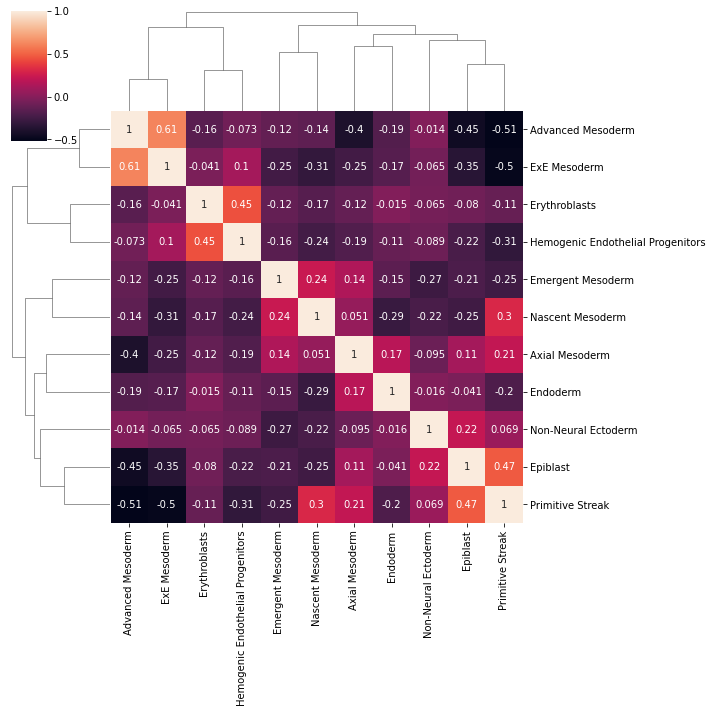

In [26]:
#sb.heatmap(clustercorr_df, cbar=False, annot=True)
sb.clustermap(clustercorr_df, cbar=True, annot=True)
#plt.savefig('cluster_correlation.png')

In [38]:
scseqDir = '/Users/idse/data_tmp/scRNAseq/201008_42hMP/'
ourdataDir = scseqDir + 'Sample_1810-KJ-1_TTGCCCGT-AATCTCAC/outs/'
MP_cluster_means_zscore = pd.read_csv(ourdataDir+'cluster_means_zscore.csv',index_col='Unnamed: 0');

In [39]:
MP_cluster_means_zscore

,AL627309.5 (ENSG00000241860),LINC01409 (ENSG00000237491),LINC01128 (ENSG00000228794),LINC00115 (ENSG00000225880),FAM41C (ENSG00000230368),AL645608.2 (ENSG00000230699),AL645608.4 (ENSG00000241180),LINC02593 (ENSG00000223764),SAMD11 (ENSG00000187634),NOC2L (ENSG00000188976),...,MT-ND4 (ENSG00000198886),MT-ND5 (ENSG00000198786),MT-ND6 (ENSG00000198695),MT-CYB (ENSG00000198727),AC011043.1 (ENSG00000276256),AL592183.1 (ENSG00000273748),AC240274.1 (ENSG00000271254),AC004556.3 (ENSG00000276345),AC007325.4 (ENSG00000278817),AC007325.2 (ENSG00000277196)
iMeLC,0.001021,0.055786,-0.002700,0.004954,-0.006345,-0.015481,0.019373,-0.030067,0.004999,0.052364,...,0.078772,0.044819,0.040820,-0.011882,0.067284,0.004969,0.015856,-0.013970,-0.238751,-0.094092
pluri,-0.064936,-0.027495,-0.054748,-0.015151,-0.014897,-0.091377,-0.079997,-0.293060,-0.695729,0.086199,...,0.125036,0.030217,0.124059,-0.205900,0.034366,0.008557,-0.011501,0.031852,-0.289109,0.008841
AMLC,0.021164,-0.020023,0.106514,0.017983,-0.021007,0.077052,0.129857,0.461198,0.788423,-0.387222,...,-0.450577,-0.146786,-0.330772,0.397294,-0.144346,-0.005445,-0.008435,-0.027297,1.219141,0.210847
PS,0.123217,-0.022223,0.010630,0.037178,0.050906,0.213717,-0.019874,0.141459,0.611403,0.149595,...,0.112180,0.053986,0.048714,0.085992,-0.052682,0.016478,-0.016100,-0.038141,-0.232986,-0.145936
PGC,0.107407,-0.086200,0.044395,-0.057635,0.098078,0.039951,0.055943,0.470201,0.917623,-0.111816,...,-0.275488,-0.155469,-0.199575,0.066299,-0.145939,-0.097161,0.030439,0.035997,0.498431,0.289134
ExMe,-0.331231,-0.343149,-0.016465,-0.147420,-0.136663,-0.220322,-0.112709,0.070859,-0.223770,-0.078008,...,-0.218940,-0.848629,-0.730087,0.605642,-0.291536,-0.209988,-0.192710,0.263802,-0.259119,-0.145936


In [41]:
# gastrula data hvg
data_sqrt_hvg = scprep.select.highly_variable_genes(data_sqrt, percentile=90)

In [49]:
data_sqrt_hvg.shape

(1195, 2242)

In [50]:
# get MP columns for hvg of gastrula
gastrula_hvg = list(data_sqrt_hvg.columns);
gastrula_hvg = ['^' + item + '($| )' for item in gastrula_hvg]
MP_c, MP_s = select_genes(MP_cluster_means_zscore,gastrula_hvg)

In [53]:
# get intersection between gene lists
gastrula_hvg = list(data_sqrt_hvg.columns);
combined_hvg = list(set(MP_s).intersection(gastrula_hvg));
combined_hvg = ['^' + item + '($| )' for item in combined_hvg]

In [54]:
# this leads to a replicate name
MP_c, MP_s = select_genes(MP_cluster_means_zscore,combined_hvg)
print(len(MP_s))
print(len(np.unique(MP_s)))

2101
2100


In [55]:
# remove doubles
[usymbols,counts] = np.unique(MP_s,return_counts=True)
doubles = list(usymbols[counts>1])
revised_symbols = list(set(MP_s).difference(doubles))
revised_symbols = [item + '($| )' for item in revised_symbols]
len(revised_symbols)

MP_c2, MP_s2 = select_genes(MP_cluster_means_zscore,revised_symbols)
print(len(MP_s2))
print(len(np.unique(MP_s2)))

2099
2099


In [56]:
# for consistency verify that the gastrula hvg data has all these genes
data_sqrt_hvg[MP_s2].shape

(1195, 2099)

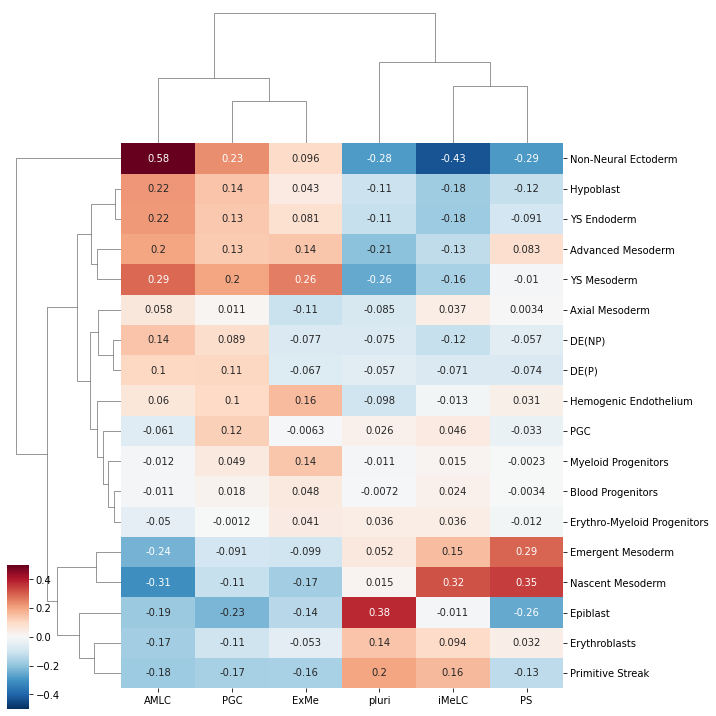

In [60]:
# cross-correlate the z-scores for both data sets
M = sub_cluster_means_zscore[MP_s2].T
N = MP_cluster_means_zscore[MP_c2].T
clustercorr = scprep.stats.pairwise_correlation(M, N)
clustercorr_df = pd.DataFrame(clustercorr,columns=N.columns,index=M.columns)
sb.clustermap(clustercorr_df, cbar=True, vmax=0.5, vmin=-0.5,annot=True,cbar_pos=(0.01,0.01,0.03,0.2),cmap='RdBu_r')
plt.savefig(ourdataDir + 'correlate_gastrula_subcluster_hvg.png')

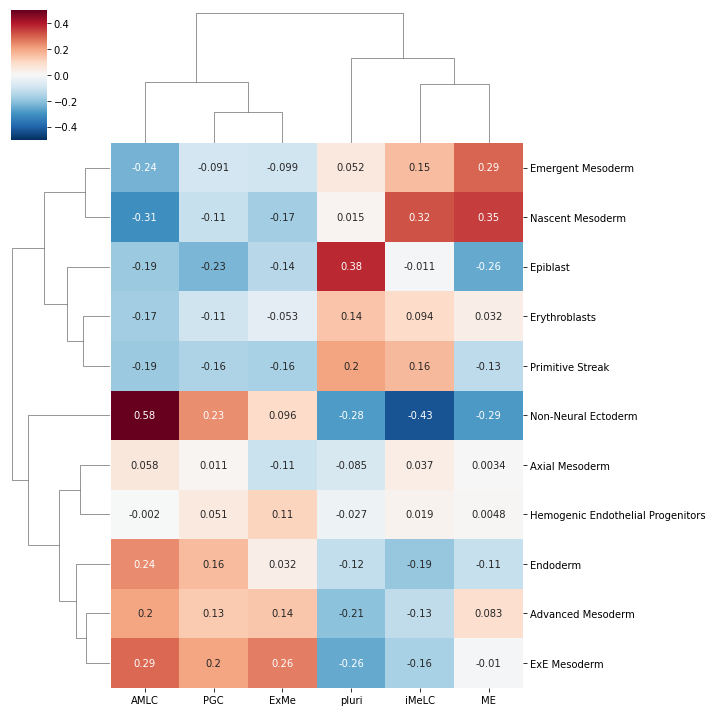

In [58]:
M = cluster_means_zscore[MP_s2].T
N = MP_cluster_means_zscore[MP_c2].T
clustercorr = scprep.stats.pairwise_correlation(M, N)
clustercorr_df = pd.DataFrame(clustercorr,columns=N.columns,index=M.columns)
sb.clustermap(clustercorr_df, cbar=True, annot=True,vmax=0.5, vmin=-0.5,cmap='RdBu_r')
plt.savefig(ourdataDir + 'correlate_gastrula_cluster_hvg.png')